In [22]:
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
import pandas as pd
import numpy as np

In [23]:
df = pd.read_csv('mnist_train.csv')
df_test=pd.read_csv('mnist_test.csv')

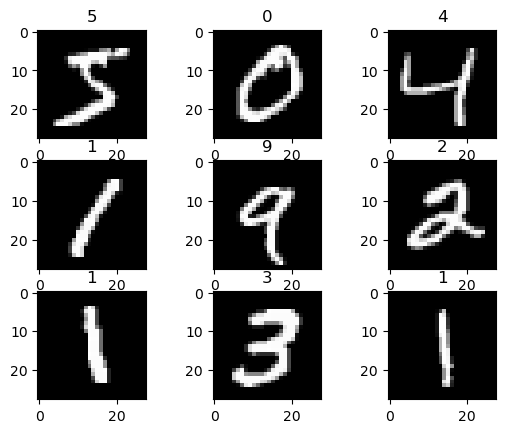

In [24]:
# Extract first 9 rows from training data and display them as image and their label as subplot title
for i in range(9):
 # define subplot
    plt.subplot(330 + 1 + i)
    
    row = df.iloc[i,1:]
    # Reshape the row to a 28x28 array
    reshaped_array = np.array(row).reshape(28, 28)
    # plot raw pixel data
    plt.imshow(reshaped_array, cmap=plt.get_cmap('gray'))
    plt.title(df.iloc[i,0])
# show the figure
plt.show()

# Print the reshaped array
#print(reshaped_array.shape)

In [25]:
df.shape

(60000, 785)

In [26]:
train_data=np.array(df.iloc[0:,1:])
train_data=train_data.reshape((train_data.shape[0], 28, 28, 1))
print(train_data.shape)
train_label=np.array(df.iloc[0:,0]).reshape(df.shape[0],1)
#train_label=df.iloc[0:,0]
 # one hot encode target values
train_label = to_categorical(train_label)
print(train_label.shape)
print(train_label[2])

(60000, 28, 28, 1)
(60000, 10)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [8]:
test_data=np.array(df_test.iloc[0:,1:])
test_data=test_data.reshape((test_data.shape[0], 28, 28, 1))
print(test_data.shape)
test_label=np.array(df_test.iloc[0:,0]).reshape(df_test.shape[0],1)
# one hot encode target values
test_label = to_categorical(test_label)
print(test_label.shape)

(10000, 28, 28, 1)
(10000, 10)


In [9]:
#data preprocessing step to normalize pixel values between 0 and 1
# convert from integers to floats
train_norm = train_data.astype('float32')
test_norm = test_data.astype('float32')
# normalize to range 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

In [10]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
 # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    i=0
 # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
 # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
    # define model
        model = define_model()
    # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        #print(trainX.shape)
        #print(trainY.shape)
        #print(testX.shape)
        #print(testY.shape)
        
        i=i+1
    # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
    # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('accuracy for {} fold is > {:.3f}'.format(i, acc * 100.0))
    # stores scores
        scores.append(acc)
        histories.append(history)
        # save model
        model.save('trained_model.keras')
    return scores, histories

In [12]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
     # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        plt.legend()
         # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.legend()
    plt.show()

In [13]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy after 5 fold cross validation: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

C:\Users\HF\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


accuracy for 1 fold is > 98.683
accuracy for 2 fold is > 98.492
accuracy for 3 fold is > 98.675
accuracy for 4 fold is > 98.750
accuracy for 5 fold is > 98.817


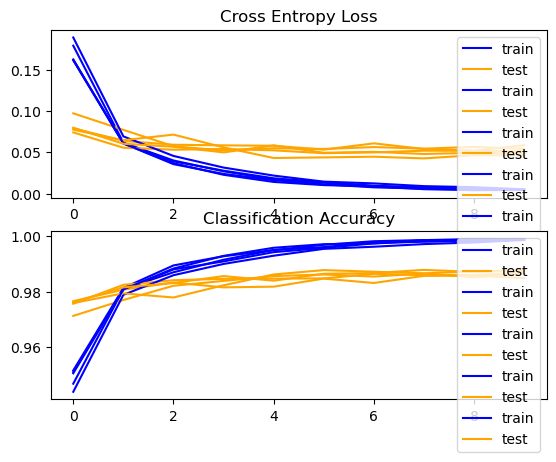

Accuracy after 5 fold cross validation: mean=98.683 std=0.109, n=5


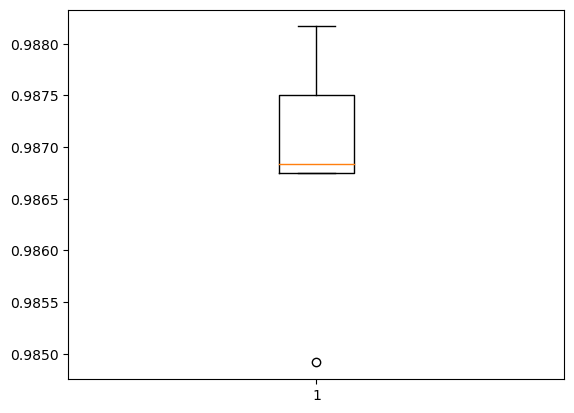

In [14]:
# evaluate model
scores, histories = evaluate_model(train_norm, train_label)
# learning curves
summarize_diagnostics(histories)
 # summarize estimated performance
summarize_performance(scores)

Enter an integer between 0 and 9999: 554
(1, 28, 28, 1)


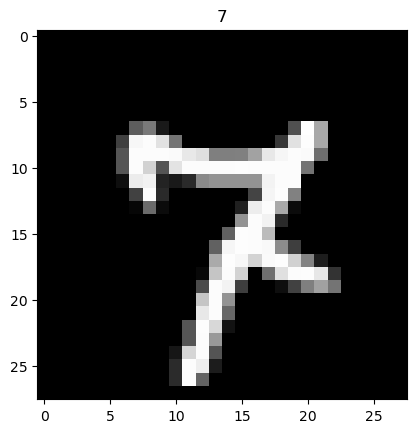

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
true label of the image is:  7
predicted label of the image is:  7
accuracy of the trained model on entire test dataset is > 98.640


In [16]:
from numpy import argmax
from keras.models import load_model

#Image Class Prediction system from test data
#You have to select any number out of 10000 test examples to predict its label 
while True:
    try:
        user_input = int(input("Enter an integer between 0 and 9999: "))
        if 0 <= user_input <= 9999:
            break
        else:
            print("Please enter a number between 0 and 9999.")
    except ValueError:
        print("Please enter a valid integer.")
   
img = df_test.iloc[user_input,1:]
true_label=df_test.iloc[user_input,0]
#Read preprocessed image
img_norm=test_norm[user_input].reshape(1, 28, 28, 1)
print(img_norm.shape)
# Reshape the required data to a 28x28 array to display it as image
gray_image = np.array(img).reshape(28, 28)
# plot raw pixel data
plt.imshow(gray_image, cmap=plt.get_cmap('gray'))
plt.title(true_label)
# show the figure
plt.show()

# load model
model = load_model('trained_model.keras')
# predict the class of selected image
predict_value = model.predict(img_norm)
predicted_label = argmax(predict_value)
print('true label of the image is: ', true_label)
print('predicted label of the image is: ', predicted_label)
#testing saved model on entire test dataset of 10,000 examples
_, acc = model.evaluate(test_norm, test_label, verbose=0)
print('accuracy of the trained model on entire test dataset is ''> %.3f' % (acc * 100.0))
